# Multi-label prediction with Planet Amazon dataset

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

# Getting the data
The planet dataset isn't available on the fastai dataset page due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API ](https://github.com/Kaggle/kaggle-api)as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

In [0]:
!pip3 install kaggle --upgrade

In [0]:
!mkdir -p ~/.kaggle/

In [0]:
! mv kaggle.json ~/.kaggle/

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You first need to go to its main page and accept its rules, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a 403 forbidden error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on Rules tab, and then scroll to the bottom to find the accept button).

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  

 99% 595M/600M [00:13<00:00, 23.8MB/s]
100% 600M/600M [00:13<00:00, 45.1MB/s]


In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path} 

  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 50.6MB/s]


In [0]:
 ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [0]:
! sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
 ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification
Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a DataBunch while using the data block API, we then need to using ImageList (and not ImageDataBunch). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\'.

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

show_batch still works, and show us the different labels separated by ;.

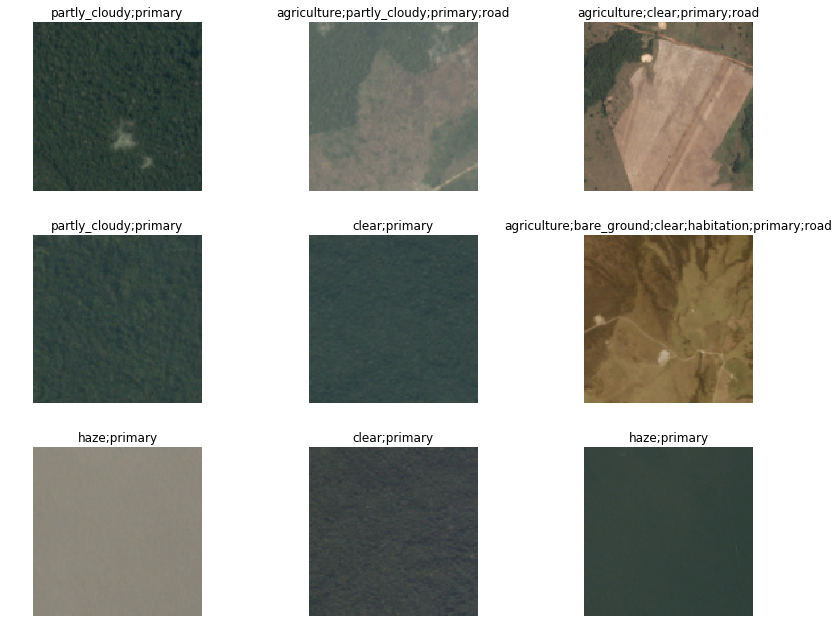

In [0]:
data.show_batch(rows=3, figsize=(12,9))

To create a Learner we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 164691268.23it/s]


We use the LR Finder to pick a good learning rate.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


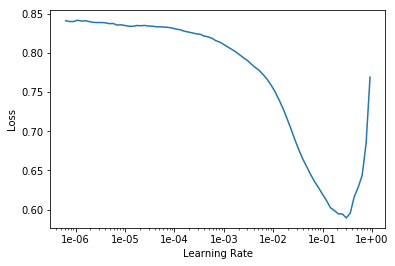

In [0]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.125268,0.119507,0.933641,0.882681,02:28
1,0.108756,0.100604,0.954540,0.908907,02:25
2,0.103169,0.092517,0.954867,0.921089,02:25
3,0.094274,0.087398,0.956160,0.924494,02:24
4,0.090627,0.086292,0.956495,0.926008,02:24


In [0]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


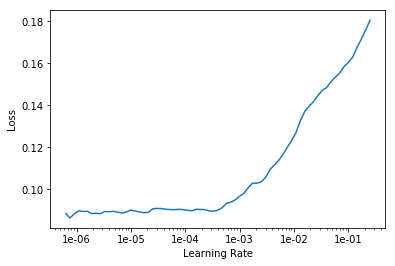

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095349,0.090028,0.955695,0.920311,02:32
1,0.095107,0.088823,0.952810,0.921696,02:32
2,0.090513,0.085638,0.956582,0.925422,02:33
3,0.086701,0.082933,0.957810,0.927895,02:32
4,0.078598,0.082317,0.957919,0.928603,02:32


In [0]:
learn.save('stage-2-rn50')

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


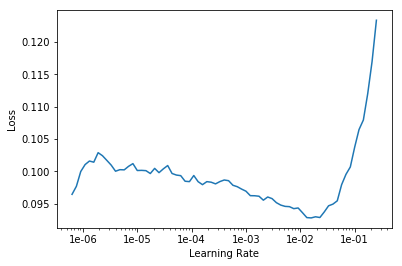

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088841,0.085529,0.958391,0.928094,05:26
1,0.087751,0.084483,0.957694,0.927109,05:25
2,0.086078,0.081902,0.959387,0.929589,05:25
3,0.080595,0.081764,0.960135,0.931663,05:25
4,0.079083,0.081371,0.959314,0.931165,05:26


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084076,0.083254,0.956785,0.929081,07:23
1,0.086058,0.085571,0.957584,0.924326,07:21
2,0.081612,0.081821,0.959248,0.929608,07:21
3,0.078610,0.081252,0.958754,0.930944,07:21
4,0.073328,0.081423,0.959147,0.930415,07:22


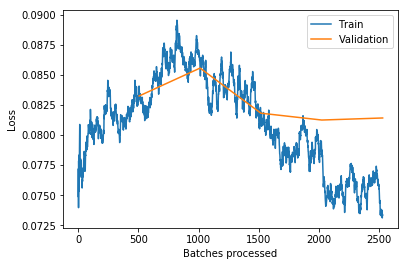

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of 0.930.

In [0]:
learn.export()

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  

100% 603M/603M [00:14<00:00, 49.1MB/s]
100% 603M/603M [00:14<00:00, 42.8MB/s]


In [0]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

 98% 297M/304M [00:08<00:00, 32.5MB/s]
100% 304M/304M [00:08<00:00, 39.2MB/s]


In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

['clear primary',
 'clear primary',
 'clear primary water',
 'clear primary',
 'agriculture clear primary road water']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100% 2.21M/2.21M [00:14<00:00, 165kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space